# Activation Patching by attention layers, mlps, and every token

In [28]:
from nnsight import LanguageModel
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [29]:
llm = LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto", torch_dtype=torch.float32)

In [31]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [37]:
# Locate the current directory
current_dir = os.getcwd()
print(f"current_dir={current_dir}")

# Read from the csv file the sentences s1, s2, and last_sentence
df = pd.read_csv(os.path.join(current_dir, "sentences.csv"))
s1 = df.iloc[0]["sentence1"]
s2 = df.iloc[0]["sentence2"]
last_sentence = df.iloc[0]["last_sentence"]

prompt = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
prompt_reversed = f"{s2}\n{s1}\nNow I will give the correct answer.\n{last_sentence}"   

corrupted_prompt = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"
corrupted_prompt_reversed = f"{s2}\n{s1}\nNow I will give the incorrect answer.\n{last_sentence}"

prompts = [prompt, corrupted_prompt]
prompts_reversed = [prompt_reversed, corrupted_prompt_reversed]

# Define the answers to these prompts, formatted as (correct, incorrect)
answers = [
    (df.iloc[0]["answer_sentence1"], df.iloc[0]["answer_sentence2"]),
    (df.iloc[0]["answer_sentence2"], df.iloc[0]["answer_sentence1"])
]

# Tokenize clean and corrupted prompts
clean_tokens = llm.tokenizer(prompts[0], return_tensors="pt")["input_ids"]
corrupted_tokens = llm.tokenizer(prompts[1], return_tensors="pt")["input_ids"]

answer_token_indices = [
    [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
    for i in range(len(answers))
]

# print("Prompts:")
# for i, p in enumerate(prompts):
#     print(f"  {i+1}. {p}")
    
# print("\nPrompts (Reversed):")
# for i, p in enumerate(prompts_reversed):
#     print(f"  {i+1}. {p}")
    
# print("\nAnswers:")
# for i, ans in enumerate(answers):
#     print(f"  {i+1}. Correct: '{ans[0]}', Incorrect: '{ans[1]}'")
    
# print("\nAnswer Token Indices:")
# for i, indices in enumerate(answer_token_indices):
#     print(f"  {i+1}. Correct: {indices[0]}, Incorrect: {indices[1]}")

current_dir=/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/activation_patching_experiments


In [38]:
def run_activation_patching(prompts, answer_token_indices):  
    patching_results = {layer: {"attn": {}, "mlp": {}} for layer in range(N_LAYERS)}  # Pre-allocate layer keys
    z_l = {}

    with llm.trace() as tracer:
        # Clean run, grab clean activations for layer
        with tracer.invoke(prompts[0]) as invoker:
            clean_tokens = invoker.inputs[0][0]["input_ids"][0]
            for layer in range(N_LAYERS):
                z_l[layer] = {
                    "attn": llm.model.layers[layer].self_attn.output.save(),
                    "mlp": llm.model.layers[layer].mlp.output.save()
                }
            # Get logits from lm_head
            clean_logits = llm.lm_head.output
            clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

        # Corrupter run, grab the corrupted logits for later comparison    
        with tracer.invoke(prompts[1]) as invoker:
            corrupted_tokens = invoker.inputs[0][0]["input_ids"][0]
            corrupted_logits = llm.lm_head.output
            corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()
        
    # Patching
    # Start with the activation patching: iterate through all the layers
    for layer in range(N_LAYERS):
        for token_idx in range(len(clean_tokens)):  
            with llm.trace(prompts[1]):
                # Activation patching MLP
                # mlp_output = llm.model.layers[layer].mlp.output.save() # for testing
                llm.model.layers[layer].mlp.output[:, token_idx, :] = z_l[layer]["mlp"][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["mlp"][f"token_{token_idx}"] = patched_result.item().save() 

            with llm.trace(prompts[1]):
                # Activation patching attention
                # self_attn_output = llm.model.layers[layer].self_attn.output.save() # for testing
                llm.model.layers[layer].self_attn.output[0][:, token_idx, :] = z_l[layer]["attn"][0][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["attn"][f"token_{token_idx}"] = patched_result.item().save() 

    return patching_results, corrupted_logit_difference, clean_logit_difference, corrupted_tokens, clean_tokens

        

In [39]:
patching_results, corrupted_logit_difference, clean_logit_difference, corrupted_tokens, clean_tokens = run_activation_patching(prompts, answer_token_indices)
patching_results_total = {
    "clean_run_logit_difference": clean_logit_difference,
    "corrupted_run_logit_difference": corrupted_logit_difference,
    "patching_results": patching_results
}

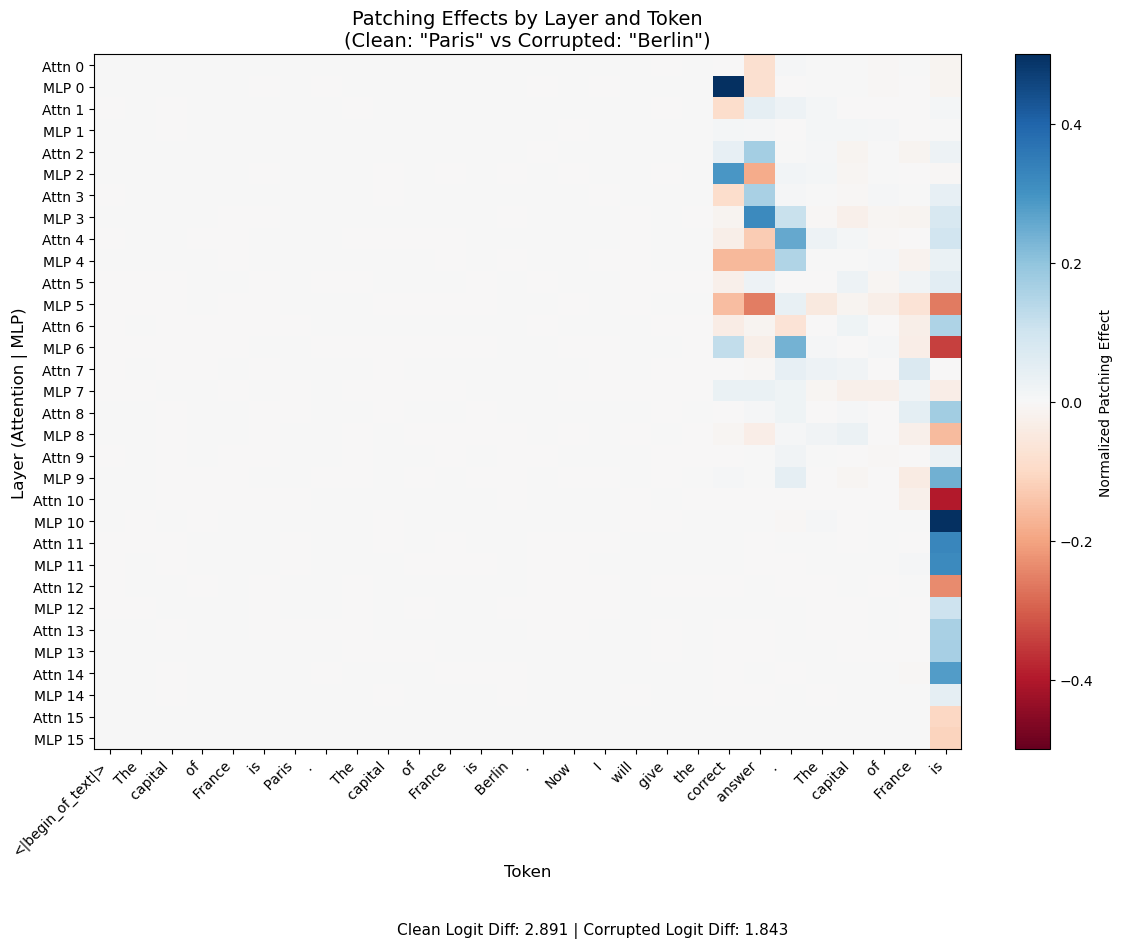

In [40]:
plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, clean_tokens)

In [34]:
def plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, clean_tokens):
    # Plotting: Single heatmap with Attention and MLP interleaved on Y-axis
    N_LAYERS = len(patching_results)
    seq_len = len(clean_tokens)

    # Extract data for attention and MLP, interleaving them on the Y-axis
    combined_effects = np.zeros((N_LAYERS * 2, seq_len))  # Each layer has two rows: Attention and MLP

    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results[layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results[layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    clean_diff = float(patching_results_total["clean_run_logit_difference"].item())
    corrupted_diff = float(patching_results_total["corrupted_run_logit_difference"].item())

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    im = plt.imshow(combined_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    plt.colorbar(im, label='Normalized Patching Effect')

    # Customize axes
    token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
    plt.xlabel('Token', fontsize=12)
    plt.ylabel('Layer (Attention | MLP)', fontsize=12)
    plt.title('Patching Effects by Layer and Token\n(Clean: "Paris" vs Corrupted: "Berlin")', fontsize=14)

    # X-axis: Token labels
    plt.xticks(np.arange(seq_len), labels=token_labels, fontsize=10, rotation=45, ha='right')

    # Y-axis: Interleave Attention and MLP labels for each layer
    y_labels = []
    for layer in range(N_LAYERS):
        y_labels.extend([f'Attn {layer}', f'MLP {layer}'])
    plt.yticks(np.arange(N_LAYERS * 2), labels=y_labels, fontsize=10)

    # Add clean/corrupted context
    plt.figtext(0.5, 0.01, f'Clean Logit Diff: {clean_diff:.3f} | Corrupted Logit Diff: {corrupted_diff:.3f}', 
                fontsize=11, ha='center')

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig('patching_effects_heatmap_single.pdf', format='pdf', dpi=300)
    plt.show()